<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>
    * <a href='#data:feature'>Feature selection</a>


* <a href='#model'>Model definition and hyperparameter optimization</a>
    * <a href='#model:cat_oc'>One Class classification models</a>
        * <a href='#model_oc:ocsvm'>One Class SVM</a>
        * <a href='#model_oc:AU'>One Class AutoEncoder</a>
        * <a href='#model_oc:...'>...</a>
        
    * <a href='#model:cat_binary'>Binary (supervised) classification models</a>
        * <a href='#model_binary:svm'>SVM</a>
        * <a href='#model_binary:AU'>Autoencoder</a>
        * <a href='#model_binary:...'>...</a>

        
* <a href='#results'>Results</a>
* <a href='#conclusions'>Conclusions</a>


    


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [234]:
import pandas as pd
import sklearn
import numpy as np
from scipy import stats

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

# Plot
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from prettytable import PrettyTable
sns.set()

# Configuration
from tqdm.notebook import tqdm
import warnings
from ipywidgets import IntProgress
from IPython import display
import time
import os
import json

# Models
from sklearn.svm import OneClassSVM
from pyod.models import ocsvm, auto_encoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, auc, plot_roc_curve
from sklearn.metrics import confusion_matrix


**Environment configuration**

In [2]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None, range_rows=10)

<a href='#index'>...</a>
<a id='data'></a>
# Processed data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [272]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_223
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [273]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
ms = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, ms):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
              
    CORE_collection[RS] = (X[0]['CORE'],X[1]['CORE'])
    X_collection[RS] = (X[0].drop(columns=['CORE']), X[1].drop(columns=['CORE']))
    Y_collection[RS] = (Y[0], Y[1])

    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

**Function definition**

In [15]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [16]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [17]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [18]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y==1]
    anomaly_index = index[Y==-1]
    X_normal = X.iloc[normal_index]
    X_anomaly = X.iloc[anomaly_index]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [19]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

**0 value percetange per column.**

Printing the percentage of samples with value 0 per all columns. Excluiding those features which have 0 as a suitable value.

In [20]:
zero_relevance_columns = ['CT0000ADW', 'CT00000AP', 'CT000APTT', 'CT00000BT', 'CT000CHCM', 'CT00000DD', 'CT0000GGT', 'CT0000GLU', 'CT0000GOT', 'CT0000GPT', 'CT0000HCM', 'CT000HCTO', 'CT0000HEM', 'CT0000HGB', 'CT0000INR', 'CT000000K', 'CT0000LDH', 'CT000LEUC', 'CT0000LIN', 'CT000LINP', 'CT00MONOP', 'CT00000NA', 'CT0000NEU', 'CT000NEUP', 'CT0000PCR', 'CT000PLAQ', 'CT00000TP', 'CT000000U', 'CT0000VCM', 'CT0000VPM', 'CTHSDXXRATE','CTHSDXXSAT']
zero_relevance(X_data, zero_relevance_columns)

Percentage of 0's per column:
* CT0000ADW 	0 (0.00%)
* CT00000AP 	0 (0.00%)
* CT000APTT 	0 (0.00%)
* CT00000BT 	0 (0.00%)
* CT000CHCM 	0 (0.00%)
* CT00000DD 	0 (0.00%)
* CT0000GGT 	0 (0.00%)
* CT0000GLU 	0 (0.00%)
* CT0000GOT 	0 (0.00%)
* CT0000GPT 	0 (0.00%)
* CT0000HCM 	0 (0.00%)
* CT000HCTO 	0 (0.00%)
* CT0000HEM 	0 (0.00%)
* CT0000HGB 	0 (0.00%)
* CT0000INR 	0 (0.00%)
* CT000000K 	0 (0.00%)
* CT0000LDH 	0 (0.00%)
* CT000LEUC 	0 (0.00%)
* CT0000LIN 	0 (0.00%)
* CT000LINP 	0 (0.00%)
* CT00MONOP 	0 (0.00%)
* CT00000NA 	0 (0.00%)
* CT0000NEU 	0 (0.00%)
* CT000NEUP 	0 (0.00%)
* CT0000PCR 	0 (0.00%)
* CT000PLAQ 	0 (0.00%)
* CT00000TP 	0 (0.00%)
* CT000000U 	0 (0.00%)
* CT0000VCM 	0 (0.00%)
* CT0000VPM 	0 (0.00%)
* CTHSDXXRATE 	0 (0.00%)
* CTHSDXXSAT 	0 (0.00%)


**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

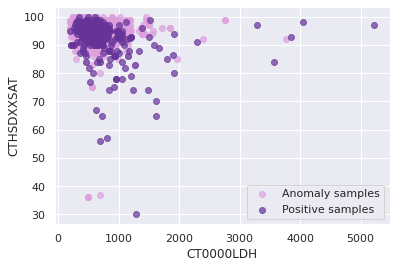

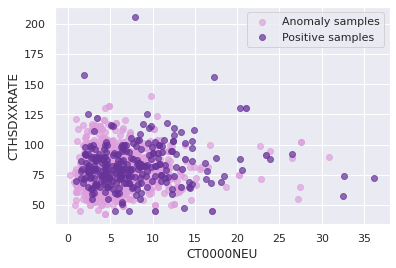

In [22]:
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

Text(0.5, 1.08, "Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)")

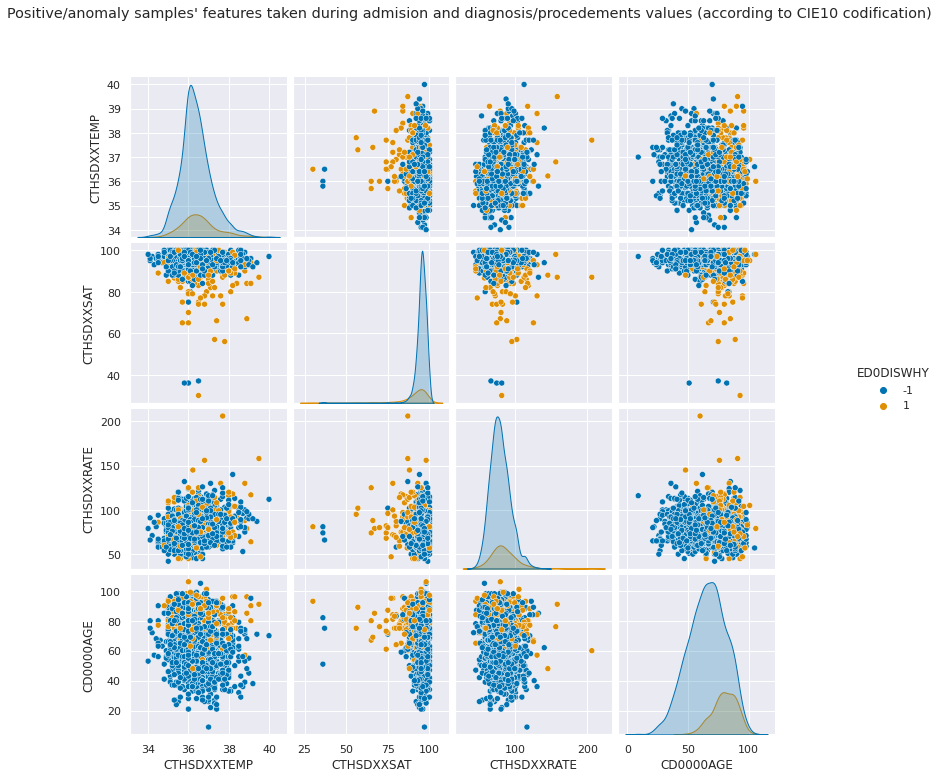

In [23]:
pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.



<a id='data:feature'></a>
## Feature selection

**Row removal for predefined thresholds**

In [ ]:
universe = 42

# CT0000DD > 10000
index = X_collection[universe][0].loc[X_collection[universe][0]['CT00000DD']>10000].index.tolist()
# CT0000GOT > 200
index += X_collection[universe][0].loc[X_collection[universe][0]['CT0000GOT']>200].index.tolist()
# CT0000GPT > 200
index += X_collection[universe][0].loc[X_collection[universe][0]['CT0000GPT']>200].index.tolist()

index = np.unique(index)
# Remove rows
X_collection[universe][0].drop(labels=index, axis=0, inplace=True)
Y_collection[universe][0].drop(labels=index, axis=0, inplace=True)
CORE_collection[universe][0].drop(labels=index, axis=0, inplace=True)
# Reset the indexes
X_collection[universe][0].reset_index(drop=True, inplace=True)
Y_collection[universe][0].reset_index(drop=True, inplace=True)
CORE_collection[universe][0].reset_index(drop=True, inplace=True)
print(f'Removed a total of {len(index)} rows.')

**Histogram of features**


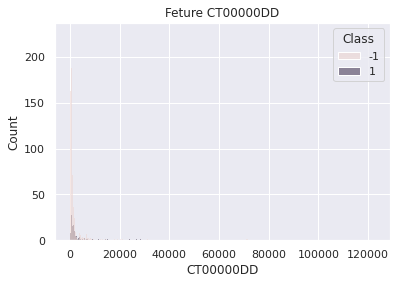

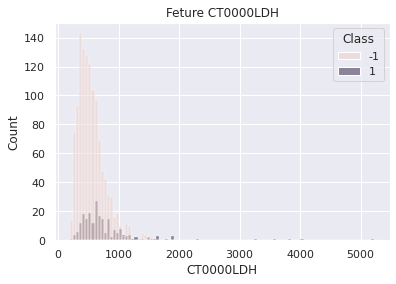

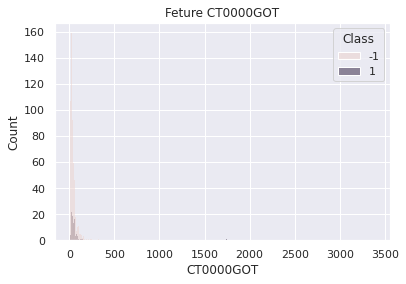

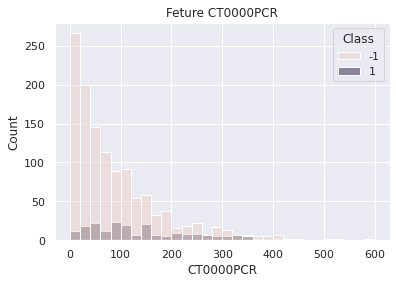

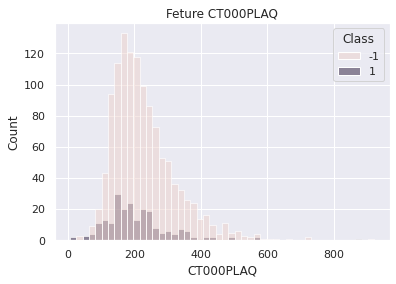

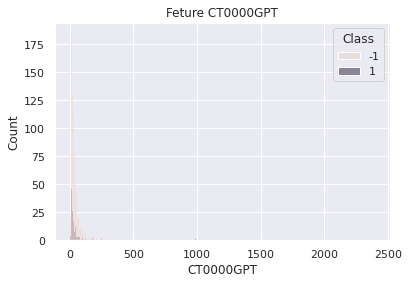

In [24]:
universe = 42

data = X_collection[universe][0]
data['Class'] = Y_collection[universe][0]['ED0DISWHY']

feat = 'CT00000DD'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000LDH'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000GOT'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000PCR'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT000PLAQ'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000GPT'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

**Selecting features based on variance**

* **Ranking features based on variance (most to least)**

In [ ]:
## Feature selection / filtering based on ranking features based on variance (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 26

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

variance = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        var = X_collection[universe][0][col].var()
        variance[col] = var
    
    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(variance)), variance): 
        print(f"{i+1}. {col}: {variance[col]:.3f}")
        
    variance_keys = list(variance.keys())
    
    X_collection[universe][0].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{variance_keys[-total_columns-columns_to_drop:]}\n')

* **Ranking features based on MAD (most to least)**

In [177]:
## Feature selection / filtering based on ranking features based on MAD (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 20

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

mad_list = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        mad_list[col] = mad
    
    mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(mad_list)), mad_list): 
        print(f"{i+1}. {col}: {mad_list[col]:.3f}")
        
    mad_keys = list(mad_list.keys())
    
    X_collection[universe][0].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{mad_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 20

Universe 42 top variance:
1. CT00000DD: 362.300
2. CT0000LDH: 138.100
3. CT000PLAQ: 53.000
4. CT0000PCR: 47.920
5. CT0000GGT: 25.500
6. CT0000GLU: 16.000
7. CT0000GOT: 11.950
8. CT0000GPT: 11.900
9. CT000000U: 10.500
10. CT00000AP: 9.000
11. CT000NEUP: 9.000
12. CTHSDXXRATE: 9.000
13. CT000LINP: 7.250
14. CT0000VCM: 3.100
15. CT000HCTO: 3.100
16. CT00MONOP: 2.500
17. CT000APTT: 2.400
18. CT00000NA: 2.200
19. CT000LEUC: 1.885
20. CT0000NEU: 1.670
21. CT0000HCM: 1.200
22. CT0000HGB: 1.200
23. CT0000ADW: 1.100
24. CT00000TP: 1.000
25. CT000CHCM: 0.800
26. CT0000VPM: 0.700
27. CTHSDXXTEMP: 0.400
28. CT0000HEM: 0.390
29. CT0000LIN: 0.350
30. CT000000K: 0.330
31. CT000CREA: 0.190
32. CT000MONO: 0.165
33. CT00000BT: 0.142
34. CT000BASP: 0.100
35. CT000EOSP: 0.100
36. CT0000INR: 0.090
37. CT0000BAS: 0.010
38. CT0000EOS: 0.010
39. CT0000COM: 0.000
40. CT0000SYM: 0.000
Removed features in universe 42:
['CT0000HCM', 'CT0000HGB', 'CT0000ADW', 'CT00000TP', 'CT000CHCM'

* **Ranking features based on variance RATIO (most to least)**

In [241]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 10

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        var = X_collection[universe][0][col].var()
        # Variance with normal samples
        var_pos = X_collection[universe][0][col][positive_index].var()
        ratio_value = var/var_pos
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
#     print(f'Universe {universe} top variance:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.3f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 10

Original feature size: 44. New feature size: 34.

Removed features in universe 42:
['CT0000BAS', 'CT0000HCM', 'CT0000LIN', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT0000SYM', 'CT000BASP', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 89:
['CT000CHCM', 'CT0000HCM', 'CT0000BAS', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT000BASP', 'CT0000SYM', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 101:
['CT000CHCM', 'CT0000LIN', 'CT000NEUP', 'CT0000BAS', 'CT0000GGT', 'CT000LINP', 'CT000BASP', 'CT0000SYM', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 151:
['CT000CHCM', 'CT0000BAS', 'CT0000HCM', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT000BASP', 'CT0000SYM', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 189:
['CT0000VPM', 'CT0000HCM', 'CT000NEUP', 'CT0000LIN', 'CT000LINP', 'CT0000GGT', 'CT000BASP', 'CT0000SYM', 'CT000EOSP', 'CT0000EOS']



* **Ranking features based on MAD RATIO (most to least)**

In [274]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()


## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 25

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        # Variance with normal samples
        mad_pos = stats.median_abs_deviation(X_collection[universe][0][col][positive_index])

        # Avoid divide by 0
        ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
    
#     Print TOP features per universe
#     print(f'Universe {universe} top MAD:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.7f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 25

Original feature size: 44. New feature size: 19.

Removed features in universe 42:
['CTHSDXXTEMP', 'CT000000K', 'CT000HCTO', 'CT0000VCM', 'CT0000HGB', 'CT000CHCM', 'CT000APTT', 'CT00000AP', 'CTHSDXXRATE', 'CT000MONO', 'CT0000HCM', 'CT0000HEM', 'CT0000ADW', 'CT0000BAS', 'CT0000VPM', 'CT000BASP', 'CT0000GGT', 'CT000PLAQ', 'CT00MONOP', 'CT0000GPT', 'CT0000LIN', 'CT000NEUP', 'CT000LINP', 'CT0000EOS', 'CT000EOSP']

Removed features in universe 89:
['CT000000K', 'CT0000VCM', 'CT0000LDH', 'CT0000HGB', 'CT000APTT', 'CT000MONO', 'CT00000AP', 'CTHSDXXRATE', 'CT000HCTO', 'CT0000HCM', 'CT0000HEM', 'CT0000ADW', 'CT0000BAS', 'CT0000VPM', 'CT000BASP', 'CTHSDXXTEMP', 'CT0000GGT', 'CT000PLAQ', 'CT00MONOP', 'CT0000LIN', 'CT000NEUP', 'CT0000GPT', 'CT000LINP', 'CT0000EOS', 'CT000EOSP']

Removed features in universe 101:
['CT000CHCM', 'CT0000GLU', 'CT000000K', 'CT0000VCM', 'CT000HCTO', 'CT000APTT', 'CTHSDXXTEMP', 'CT00000AP', 'CTHSDXXRATE', 'CT0000ADW', 'CT0000HCM', 'CT000MON

<a href='#index'>...</a>
<a id='model'></a>
# Model definition and hyperparameter optimization

## Function definition

In [123]:
def normalize(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [124]:
def oc_split(Y, train, test, normal):
    indexed_train = zip(np.arange(0,train.shape[0],1), train)
    # Index to remove from train set
    del_index = []

    for train_index, df_index in tqdm(indexed_train, total=train.shape[0], desc = 'Transfering anomaly samples from train to test'): 
        sample = Y.iloc[df_index]
        if (sample['ED0DISWHY']!=normal):
            # Append anomaly samples from train to test
            test = np.append(test, df_index)
            # Update train (anomaly) indexes
            del_index.append(train_index)
    # Remove anomaly samples from train
    train = np.delete(train, del_index, 0)
    return train, test


In [125]:
def nested_cv(X, Y, outer_folds, inner_folds, model, parameters, score, one_class=0, normal_target=1):

    outer_loop=1
    max_score = -1
    score_outer = []
    inner_results = []
    
    # Define outer-loop
    skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
    for train_outer, test_outer in skfold_outer.split(X, Y):
        display.clear_output(wait=True)
        
        print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))
        
        # Outer-loop data retrieve
        X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
        Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]
        
        # Define inner loop
        skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)
        
        # Transfering anomaly samples from train to test subsets.
        if (one_class):
            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((oc_split(Y, train_inner, test_inner, normal_target)))
        else:
            skfold_inner_cv = skfold_inner
            
        # GRIDSEARCH
        # Obtain best model
        scorer = make_scorer(score, pos_label=normal_target)#, average='weighted')
#         scorer = make_scorer(precision_score, pos_label=normal_target)
#         scorer = make_scorer(recall_score, pos_label=normal_target)
#         scorer = make_scorer(f1_score, pos_label=normal_target)
        gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
        gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
        inner_results.append(gsearch.cv_results_)
        
        # Best estimator
        estimator = gsearch.best_estimator_
        pred_y = estimator.predict(X_test_outer)
#         print('Predited Y: \n {} \n'.format(pred_y))
#         print('Ground truth Y: \n {} \n'.format(Y.iloc[test_outer]))
#         score = f1_score(Y.iloc[test_outer], pred_y)
#         score = precision_score(Y.iloc[test_outer], pred_y, np.unique)
        score_val = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)#,average='micro')
        score_outer.append(score_val)
        if (score_val>=max(score_outer)): best_estimator = estimator
            
        outer_loop+=1
#         time.sleep(10)
    display.clear_output(wait=True)
    
    print("Metrics: f1-score")
    print("Summary:")
    for i in range(outer_folds):
        best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
        print("Outer fold nº{}.".format(i+1))
        print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
        print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
        print("Score (outer): {:.4}\n".format(score_outer[i]))
    return best_estimator
        

In [126]:
def confusion_matrix_plot(y_true, y_pred, labels, normal, anomaly, rs='UNDEFINED'):

    array = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

    df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

    total = df_cm[normal].sum()+df_cm[anomaly].sum()

    df_cm_p = df_cm.applymap(str)
    df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
    df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
    df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
    df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

    plt.figure(figsize=(8,5))
    plt.title('Confusion matrix of universe {}'.format(rs))
    sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
    plt.ylabel("Ground truth")
    plt.xlabel("Predicted") 

    plt.show()

In [127]:
def confusion_matrix_plot_total(y_true, y_pred, labels, normal, anomaly):
    
    fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]

        array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=labels)

        df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

        total = df_cm[normal].sum()+df_cm[anomaly].sum()

        df_cm_p = df_cm.applymap(str)
        df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
        df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
        df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
        df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'
        
        sns.heatmap(df_cm, annot=df_cm_p,ax=ax, fmt='', annot_kws={"size": 15}) # font size
        ax.set_ylabel('Ground truth')
        ax.set_xlabel('Predicted')
        ax.set_title('Confusion matrix of universe {}'.format(universe))
 

In [128]:
def ROC_plot_total(y_true, outlier_score, normal):
    
    fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]
        
        norm_outlier_score = normalize(outlier_score[universe])
        fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.set_title('Receiver Operating Characteristic {}'.format(universe))
 

In [129]:
def outlierness_plot_total(y_true, y_pred, outlier_score, normal, anomaly, xlim0=-1, xlim1=-1): 
    # Visualization of the outlierness distribution
    fig, axs = plt.subplots(4,1, figsize=(10, 40))
    axs_flat = axs.flat
    
    for i, ax in enumerate(axs_flat):
        universe = ms[i]
        
        positive_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==normal].index
        negative_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==anomaly].index

        true_positive_index = y_pred[universe][positive_index].loc[y_pred[universe][positive_index]==1].index
        false_negative_index = y_pred[universe][positive_index].loc[y_pred[universe][positive_index]==-1].index

        true_negative_index = y_pred[universe][negative_index].loc[y_pred[universe][negative_index]==-1].index
        false_positive_index = y_pred[universe][negative_index].loc[y_pred[universe][negative_index]==1].index

        d = {'Outlier-score':outlier_score[universe][true_positive_index], 'Classification':len(outlier_score[universe][true_positive_index])*['True Positive']}
        df_true_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][false_positive_index], 'Classification':len(outlier_score[universe][false_positive_index])*['False Positive']}
        df_false_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][true_negative_index], 'Classification':len(outlier_score[universe][true_negative_index])*['True Negative']}
        df_true_negative = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][false_negative_index], 'Classification':len(outlier_score[universe][false_negative_index])*['False Negative']}
        df_false_negative = pd.DataFrame(data=d)

        df_scores = pd.concat([df_true_positive, df_false_positive, df_true_negative, df_false_negative])

        plt.title('Outlierness distribution')
        if (xlim0!=-1 and xlim1!=-1):
            plt.xlim([xlim0, xlim1])
        sns.boxplot(y='Classification', x='Outlier-score', data=df_scores, whis=np.inf, ax=ax)
        sns.stripplot(y='Classification', x='Outlier-score', data=df_scores, color=".25", ax=ax)



In [130]:
def metric_evaluation(y_true, y_pred, outlier_score, pos_label):
    cm = {}
    evaluations = pd.DataFrame(columns=['AUC', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-score'])
    for universe in ms:
        # Confusion matrix calculation
        array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=[pos_label,-pos_label])
        cm[universe]=(' {} {}\n{} {}'.format(array[0,0], array[0,1], array[1,0], array[1,1]))

        # Metric calculation
        # AUC, Accuracy, Precision, Sensitivity, Specifity, F1-score
        norm_outlier_score = normalize(outlier_score[universe])
        fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)
        met = [roc_auc,\
               accuracy_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
               precision_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
               recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label),\
               recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=-pos_label),\
               f1_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label)]

        evaluations.loc[universe] = met

    pt = PrettyTable()
    pt.field_names = ["Prediction"]+['Pos Neg [{}]'.format(x) for x in ms]
    pt.add_row(['Positive\nNegative']+list(cm.values()))
    pt.add_row(6*['---------------'])
    for metric in evaluations.columns:
        formated_ev = ["{:.3f}".format(x) for x in evaluations[metric]]
        max_i = np.argmax(evaluations[metric])
        formated_ev[max_i] = formated_ev[max_i]+'*'
        pt.add_row([metric]+formated_ev)

    pt.align['Prediction']='l'
    print(pt)
    
    return evaluations
    

<a id='model:cat_oc'></a>
## One Class classification models

TODO: EXPLANATION

<a id='model_oc:ocsvm'></a>
## One Class SVM
Original paper.

[source](https://www.is.mpg.de/publications/815)

Original author related paper.

[source](https://ieeexplore.ieee.org/book/6267332)

TODO: EXPLANATION
- MODEL
    - Parameters
        - Nu is the parameter that controls the training errors (and the number of SVs). This parameter is always within the range (0,1].
        - Gamma parameter determines the influence of radius on the kernel. The range of this parameter depends on your data and application.
        
        ![Medium](https://miro.medium.com/max/554/1*2uaESizmfcjljwNIs6Nm9w.png)
        Source: [Medium](https://medium.com/@mail.garima7/one-class-svm-oc-svm-9ade87da6b10)
    
- OUTLIERNESS

### One-class SVM with hyperparameter optimization.

In [226]:
ocsvm = OneClassSVM()
estimator_dict = {}
normal = 1

low_gamma = 0.1
top_gamma = 0.05

low_nu = 0.05
top_nu = 0.8

# Results made by filtering with variance RATIO (15 drop)

ocsvm_params= {
#         'gamma' : np.linspace(low_gamma, top_gamma, 5+1)[1:],
         'nu' : np.linspace(low_nu, top_nu, 50+1)[1:]
#            'nu' : np.linspace(low_nu, top_nu, 100+1)[1:]
    }

estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)

''' EXPANDED FOR ALL UNIVERSES
for universe in ms:
    # Obtain model with best hyperparameters
    estimator_dict[universe] = nested_cv(X_collection[universe][0], Y_collection[universe][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)
'''   

Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'nu': 0.44}
Score (best of cv): 0.262±0.0084
Score (outer): 0.212

Outer fold nº2.
Parameters (best of cv): {'nu': 0.065}
Score (best of cv): 0.247±0.004
Score (outer): 0.2564

Outer fold nº3.
Parameters (best of cv): {'nu': 0.065}
Score (best of cv): 0.251±0.006
Score (outer): 0.2469

Outer fold nº4.
Parameters (best of cv): {'nu': 0.065}
Score (best of cv): 0.234±0.0044
Score (outer): 0.2288

Outer fold nº5.
Parameters (best of cv): {'nu': 0.365}
Score (best of cv): 0.247±0.0024
Score (outer): 0.2703



' EXPANDED FOR ALL UNIVERSES\nfor universe in ms:\n    # Obtain model with best hyperparameters\n    estimator_dict[universe] = nested_cv(X_collection[universe][0], Y_collection[universe][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)\n'

### One-class SVM with default parameters.

In [ ]:
estimator_dict = {}
estimator_ocsvm = OneClassSVM()

**Fitting the model**

In [227]:
print("Selected parameters: ",json.dumps(estimator_ocsvm.get_params(), indent=1))
outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit model with train data
    if estimator_dict != {}: estimator_ocsvm = estimator_dict[universe]

    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_ocsvm.fit(X_collection[universe][0].iloc[index_normal])

    # Predict unproccessed outlier-score
    decicision_function = estimator_ocsvm.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(-decicision_function)
    outlier_score = -decicision_function - MIN
    
    prediction = pd.Series(estimator_ocsvm.predict(X_collection[universe][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


Selected parameters:  {
 "cache_size": 200,
 "coef0": 0.0,
 "degree": 3,
 "gamma": "scale",
 "kernel": "rbf",
 "max_iter": -1,
 "nu": 0.365,
 "shrinking": true,
 "tol": 0.001,
 "verbose": false
}


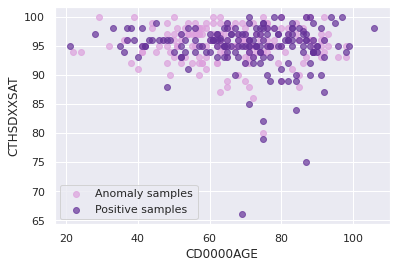

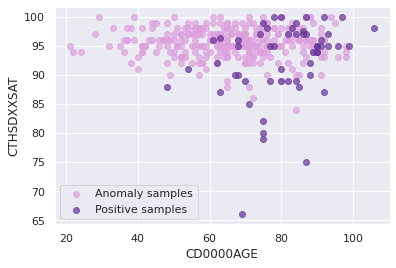

In [228]:
plot_pair_individual(X_collection[42][1], pd.Series(prediction_dict[42]), 'CD0000AGE', 'CTHSDXXSAT')
plot_pair_individual(X_collection[42][1], pd.Series(Y_collection[42][1]['ED0DISWHY']), 'CD0000AGE', 'CTHSDXXSAT')

**ROC**

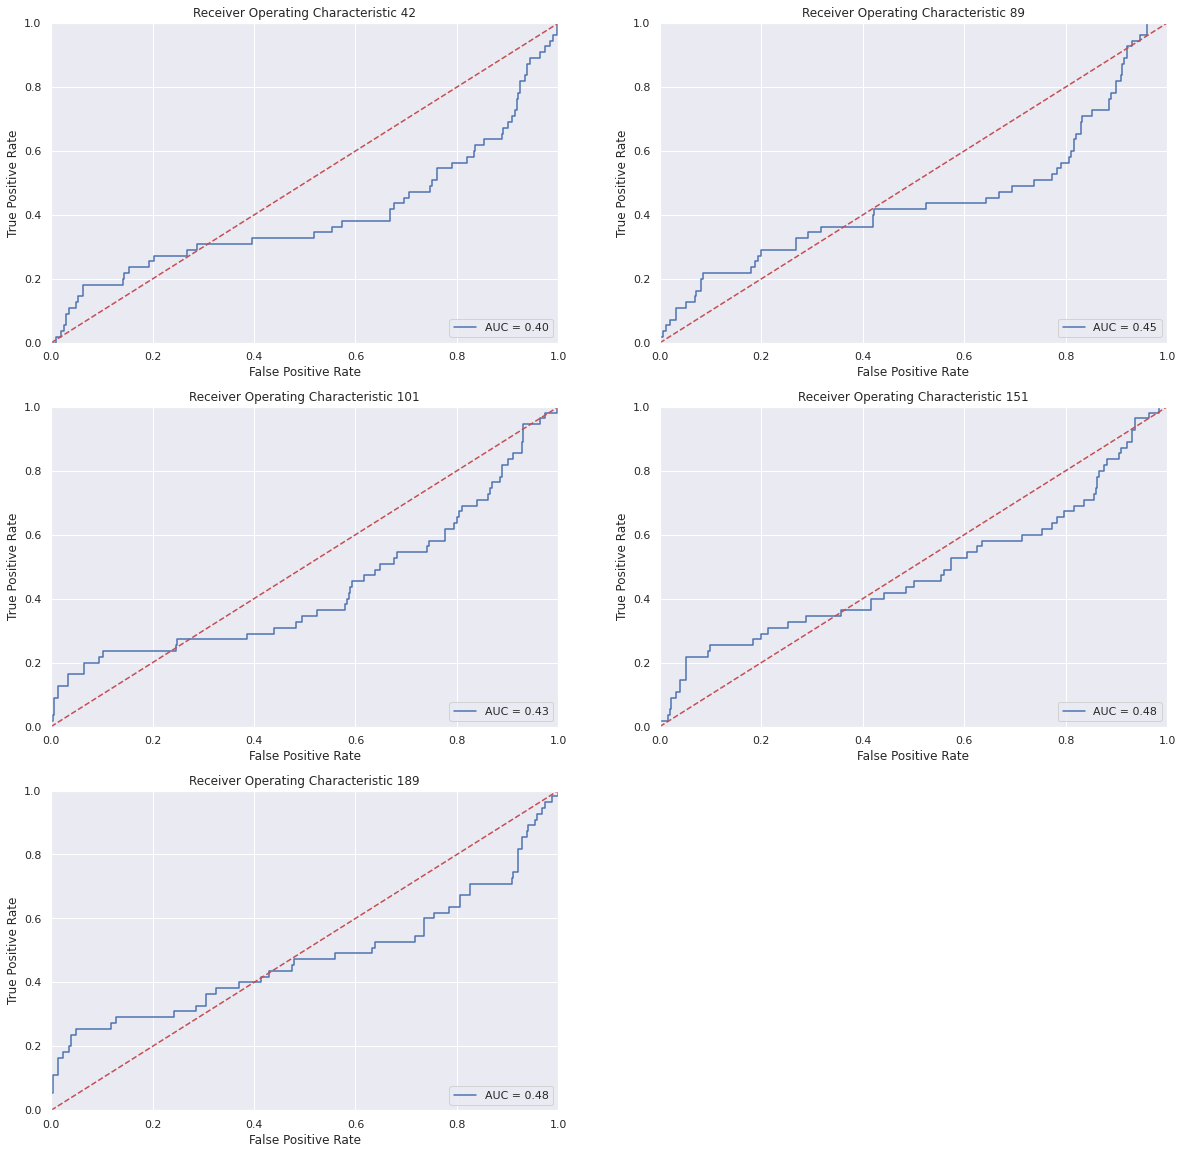

In [229]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

**Outlierness representation.**

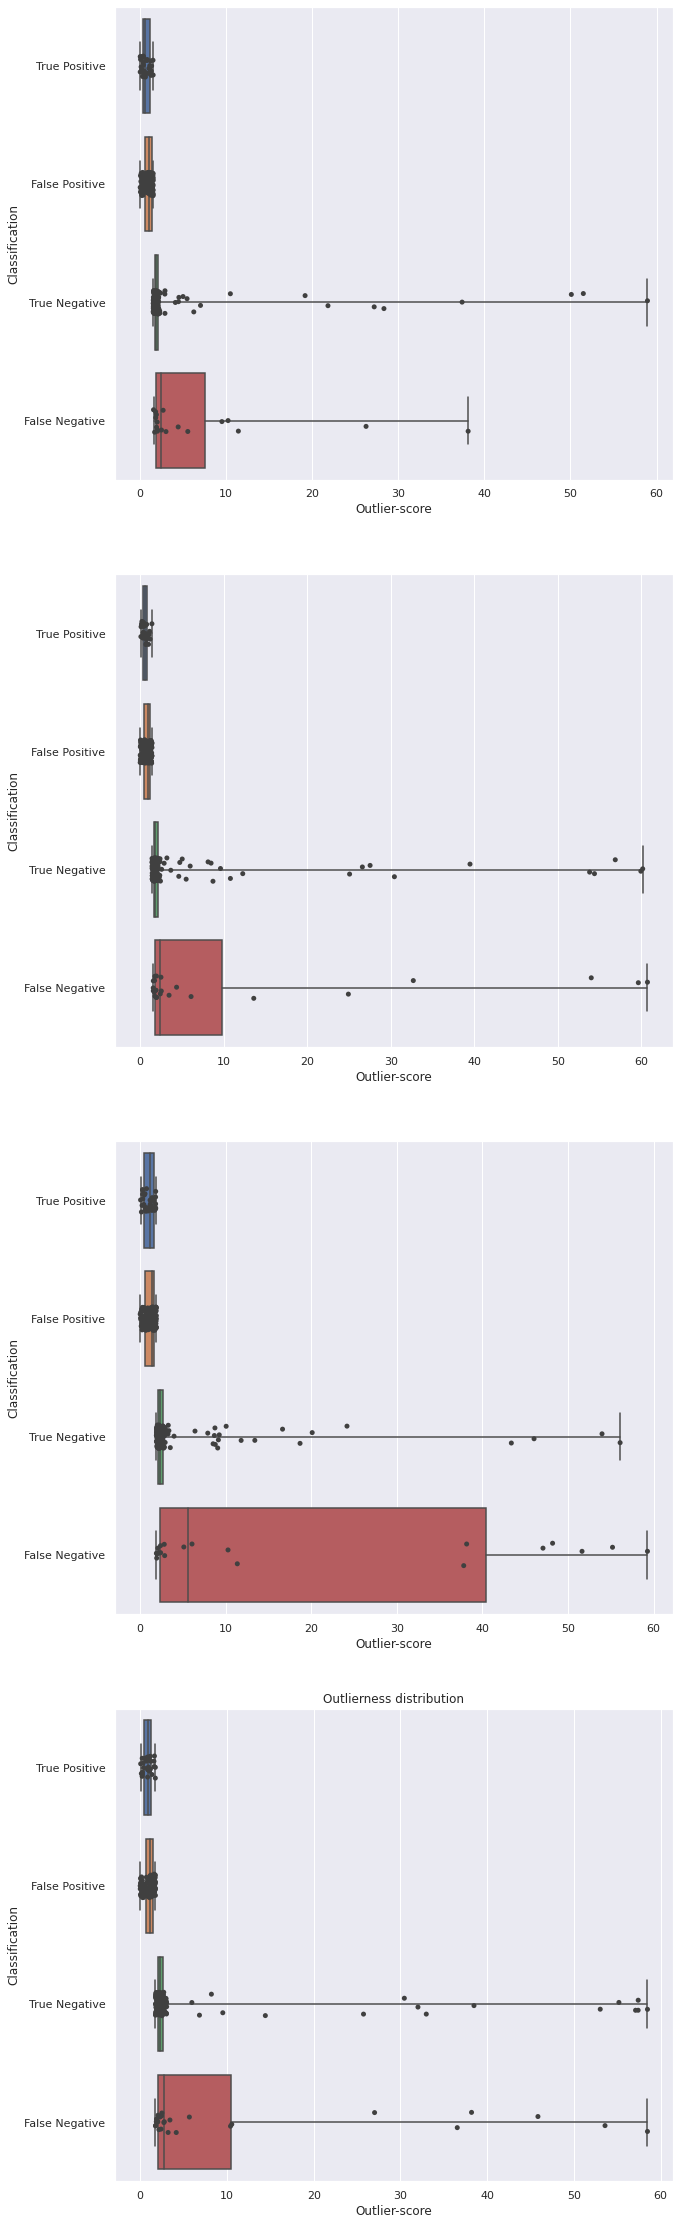

In [230]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

**Confusion matrices**

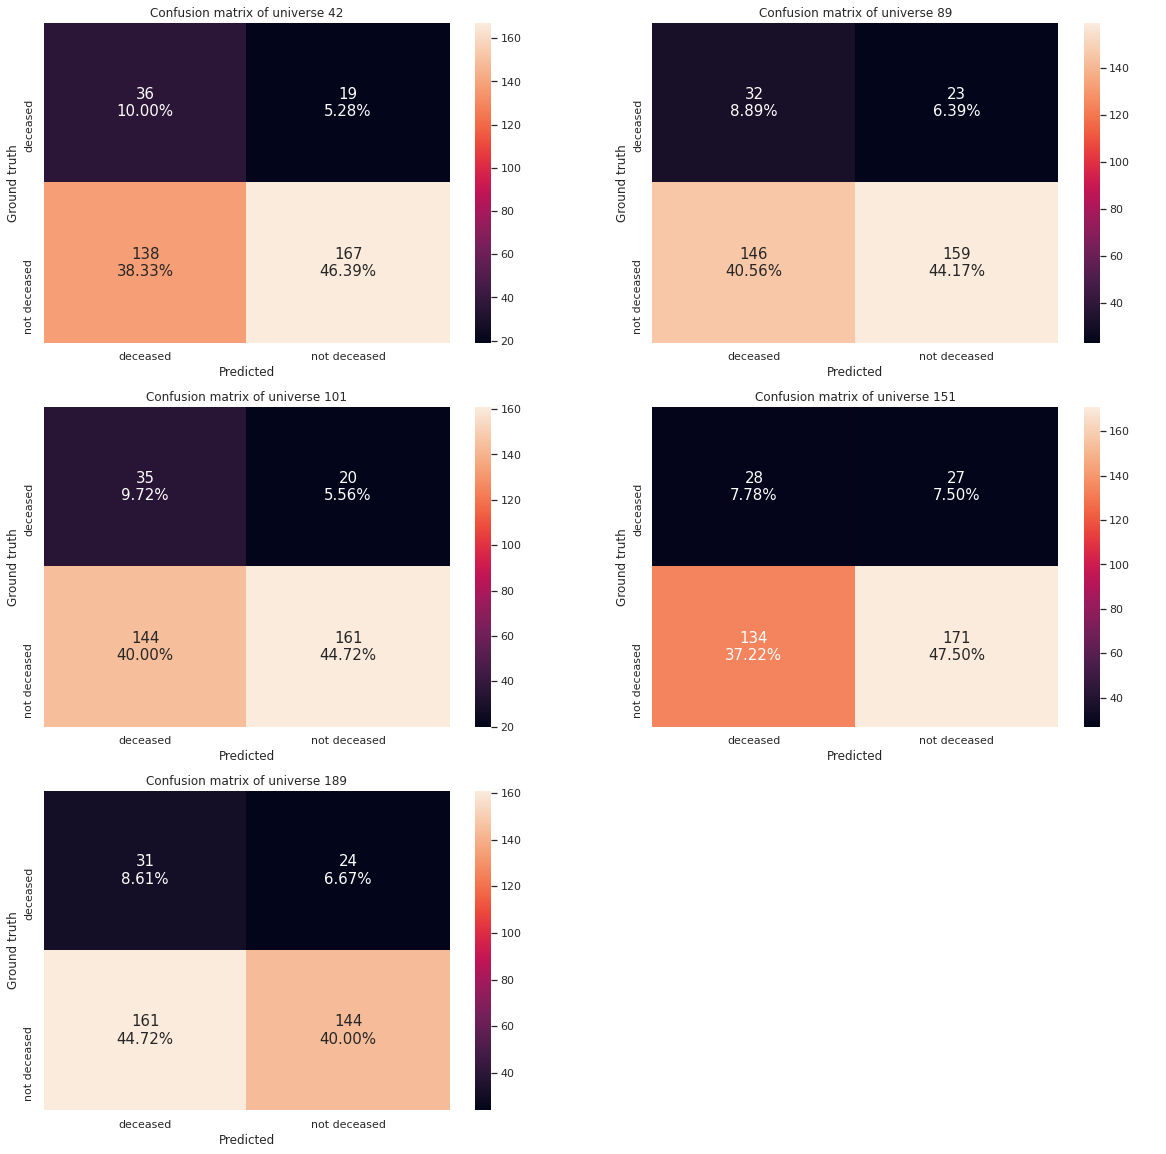

In [231]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

**Evaluation**

In [233]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       36 19     |       32 23     |       35 20     |       28 27     |       31 24     |
| Negative        |     138 167     |     146 159     |     144 161     |     134 171     |     161 144     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.397      |      0.446      |      0.433      |      0.483*     |      0.477      |
| Accuracy        |      0.564*     |      0.531      |      0.544      |      0.553      |      0.486      |
| Precision       |      0.207*     |      0.180      |      0.196      |      0.173      |      0.161      |
| Sensitiv

<a id='model_oc:ocsvm'></a>
## MODELS

## Isolation Forest

In [ ]:
iforest = IsolationForest(random_state=42)

normal = 1

iforest_params= {
    'contamination' : [0.5, 0.6, 0.7, 0.8, 0.9]
    }

# Obtain model with best hyperparameters: nested-cv
estimator_iforest = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=iforest, parameters=iforest_params, score=f1_score, one_class=1, normal_target = 1)

In [ ]:
estimator_iforest = IsolationForest(contamination=0.8, random_state=42)


In [ ]:
from sklearn.ensemble import IsolationForest

outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_iforest.fit(X_collection[universe][0].iloc[index_normal])
    
    # Predict unproccessed outlier-score
    decicision_function = estimator_iforest.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(-decicision_function)
    
    ## IsolationForest decision_function is between -0.5 and 0.5, where smaller values mean more anomalous. 
    outlier_score = -decicision_function - MIN
    
    prediction = pd.Series(estimator_iforest.predict(X_collection[universe][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


In [ ]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

In [ ]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

In [ ]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

In [ ]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

**LOF**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(novelty=True)

outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    LOF.fit(X_collection[universe][0].iloc[index_normal])

    # Predict unproccessed outlier-score
    decicision_function = LOF.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(decicision_function)
    outlier_score = decicision_function - MIN
    
    prediction = pd.Series(LOF.predict(X_collection[42][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


In [ ]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

## Autoencoder

In [299]:
X_collection[42][0].shape

(1438, 19)

In [297]:
estimator_ae = auto_encoder.AutoEncoder(hidden_neurons=[16, 8, 8, 16], contamination=0.5, epochs=100)
outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_ae.fit(X_collection[universe][0].iloc[index_normal])
    
    # Predict unproccessed ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)
    
    decicision_function = estimator_ae.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
#     MIN = min(-decicision_function)
    
    ## IsolationForest decision_function is between -0.5 and 0.5, where smaller values mean more anomalous. 
#     outlier_score = -decicision_function - MIN
    outlier_score = decicision_function
    
    prediction = pd.Series(estimator_ae.predict(X_collection[universe][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)
    prediction_dict[universe].loc[prediction_dict[universe]==0]=-1


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_392 (Dense)            (None, 19)                380       
_________________________________________________________________
dropout_336 (Dropout)        (None, 19)                0         
_________________________________________________________________
dense_393 (Dense)            (None, 19)                380       
_________________________________________________________________
dropout_337 (Dropout)        (None, 19)                0         
_________________________________________________________________
dense_394 (Dense)            (None, 16)                320       
_________________________________________________________________
dropout_338 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_395 (Dense)            (None, 8)               

7/7 [==============================] - 0s 7ms/step - loss: 1.1872 - val_loss: 2.2007
Epoch 64/100
7/7 [==============================] - 0s 5ms/step - loss: 1.1763 - val_loss: 2.1905
Epoch 65/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1787 - val_loss: 2.1798
Epoch 66/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1689 - val_loss: 2.1684
Epoch 67/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1705 - val_loss: 2.1570
Epoch 68/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1616 - val_loss: 2.1462
Epoch 69/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1604 - val_loss: 2.1367
Epoch 70/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1559 - val_loss: 2.1282
Epoch 71/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1549 - val_loss: 2.1193
Epoch 72/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1451 - val_loss: 2.1104
Epoch 73/100
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 1.7429 - val_loss: 1.8288
Epoch 26/100
7/7 [==============================] - 0s 4ms/step - loss: 1.7175 - val_loss: 1.8001
Epoch 27/100
7/7 [==============================] - 0s 5ms/step - loss: 1.7180 - val_loss: 1.7747
Epoch 28/100
7/7 [==============================] - 0s 4ms/step - loss: 1.6964 - val_loss: 1.7504
Epoch 29/100
7/7 [==============================] - 0s 4ms/step - loss: 1.6446 - val_loss: 1.7254
Epoch 30/100
7/7 [==============================] - 0s 4ms/step - loss: 1.6082 - val_loss: 1.7025
Epoch 31/100
7/7 [==============================] - 0s 4ms/step - loss: 1.6152 - val_loss: 1.6819
Epoch 32/100
7/7 [==============================] - 0s 4ms/step - loss: 1.5739 - val_loss: 1.6621
Epoch 33/100
7/7 [==============================] - 0s 4ms/step - loss: 1.5511 - val_loss: 1.6440
Epoch 34/100
7/7 [==============================] - 0s 4ms/step - loss: 1.5700 - val_loss: 1.6269
Epoch 35/100
7/7 [===============

7/7 [==============================] - 0s 26ms/step - loss: 3.7572 - val_loss: 3.4573
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 3.3975 - val_loss: 3.3340
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 3.1822 - val_loss: 3.2417
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 3.0460 - val_loss: 3.1659
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 2.9381 - val_loss: 3.0974
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 2.8239 - val_loss: 3.0353
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 2.6499 - val_loss: 2.9788
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 2.6058 - val_loss: 2.9296
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 2.4893 - val_loss: 2.8887
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 2.4335 - val_loss: 2.8522
Epoch 11/100
7/7 [======================

Epoch 85/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1794 - val_loss: 1.9235
Epoch 86/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1785 - val_loss: 1.9209
Epoch 87/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1746 - val_loss: 1.9186
Epoch 88/100
7/7 [==============================] - 0s 5ms/step - loss: 1.1769 - val_loss: 1.9157
Epoch 89/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1754 - val_loss: 1.9128
Epoch 90/100
7/7 [==============================] - 0s 5ms/step - loss: 1.1701 - val_loss: 1.9102
Epoch 91/100
7/7 [==============================] - 0s 5ms/step - loss: 1.1655 - val_loss: 1.9077
Epoch 92/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1637 - val_loss: 1.9054
Epoch 93/100
7/7 [==============================] - 0s 5ms/step - loss: 1.1612 - val_loss: 1.9032
Epoch 94/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1598 - val_loss: 1.9012
Epoch 95/100
7/7 [==

7/7 [==============================] - 0s 4ms/step - loss: 1.4069 - val_loss: 1.4173
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3952 - val_loss: 1.4083
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3945 - val_loss: 1.3995
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3777 - val_loss: 1.3911
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3696 - val_loss: 1.3834
Epoch 52/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3596 - val_loss: 1.3756
Epoch 53/100
7/7 [==============================] - 0s 5ms/step - loss: 1.3556 - val_loss: 1.3675
Epoch 54/100
7/7 [==============================] - 0s 6ms/step - loss: 1.3413 - val_loss: 1.3598
Epoch 55/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3312 - val_loss: 1.3527
Epoch 56/100
7/7 [==============================] - 0s 3ms/step - loss: 1.3269 - val_loss: 1.3459
Epoch 57/100
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 2.6541 - val_loss: 2.7262
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 2.5867 - val_loss: 2.6649
Epoch 11/100
7/7 [==============================] - 0s 4ms/step - loss: 2.5279 - val_loss: 2.6065
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 2.4895 - val_loss: 2.5535
Epoch 13/100
7/7 [==============================] - 0s 4ms/step - loss: 2.4186 - val_loss: 2.5028
Epoch 14/100
7/7 [==============================] - 0s 4ms/step - loss: 2.3596 - val_loss: 2.4543
Epoch 15/100
7/7 [==============================] - 0s 4ms/step - loss: 2.3154 - val_loss: 2.4069
Epoch 16/100
7/7 [==============================] - 0s 4ms/step - loss: 2.2867 - val_loss: 2.3618
Epoch 17/100
7/7 [==============================] - 0s 4ms/step - loss: 2.2168 - val_loss: 2.3186
Epoch 18/100
7/7 [==============================] - 0s 5ms/step - loss: 2.1856 - val_loss: 2.2777
Epoch 19/100
7/7 [===============

7/7 [==============================] - 0s 4ms/step - loss: 1.1585 - val_loss: 1.2962
Epoch 93/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1539 - val_loss: 1.2938
Epoch 94/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1526 - val_loss: 1.2915
Epoch 95/100
7/7 [==============================] - 0s 3ms/step - loss: 1.1497 - val_loss: 1.2893
Epoch 96/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1496 - val_loss: 1.2872
Epoch 97/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1447 - val_loss: 1.2853
Epoch 98/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1414 - val_loss: 1.2834
Epoch 99/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1451 - val_loss: 1.2815
Epoch 100/100
7/7 [==============================] - 0s 4ms/step - loss: 1.1451 - val_loss: 1.2796


In [292]:
prediction_dict[42]

0      1
1      1
2      1
3      1
4      1
      ..
355   -1
356    1
357    1
358    1
359    1
Length: 360, dtype: int64

In [300]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       25 30     |       22 33     |       27 28     |       29 26     |       20 35     |
| Negative        |      305 0      |      305 0      |      305 0      |      305 0      |      305 0      |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.000      |      0.000      |      0.018*     |      0.000      |      0.018      |
| Accuracy        |      0.069      |      0.061      |      0.075      |      0.081*     |      0.056      |
| Precision       |      0.076      |      0.067      |      0.081      |      0.087*     |      0.062      |
| Sensitiv

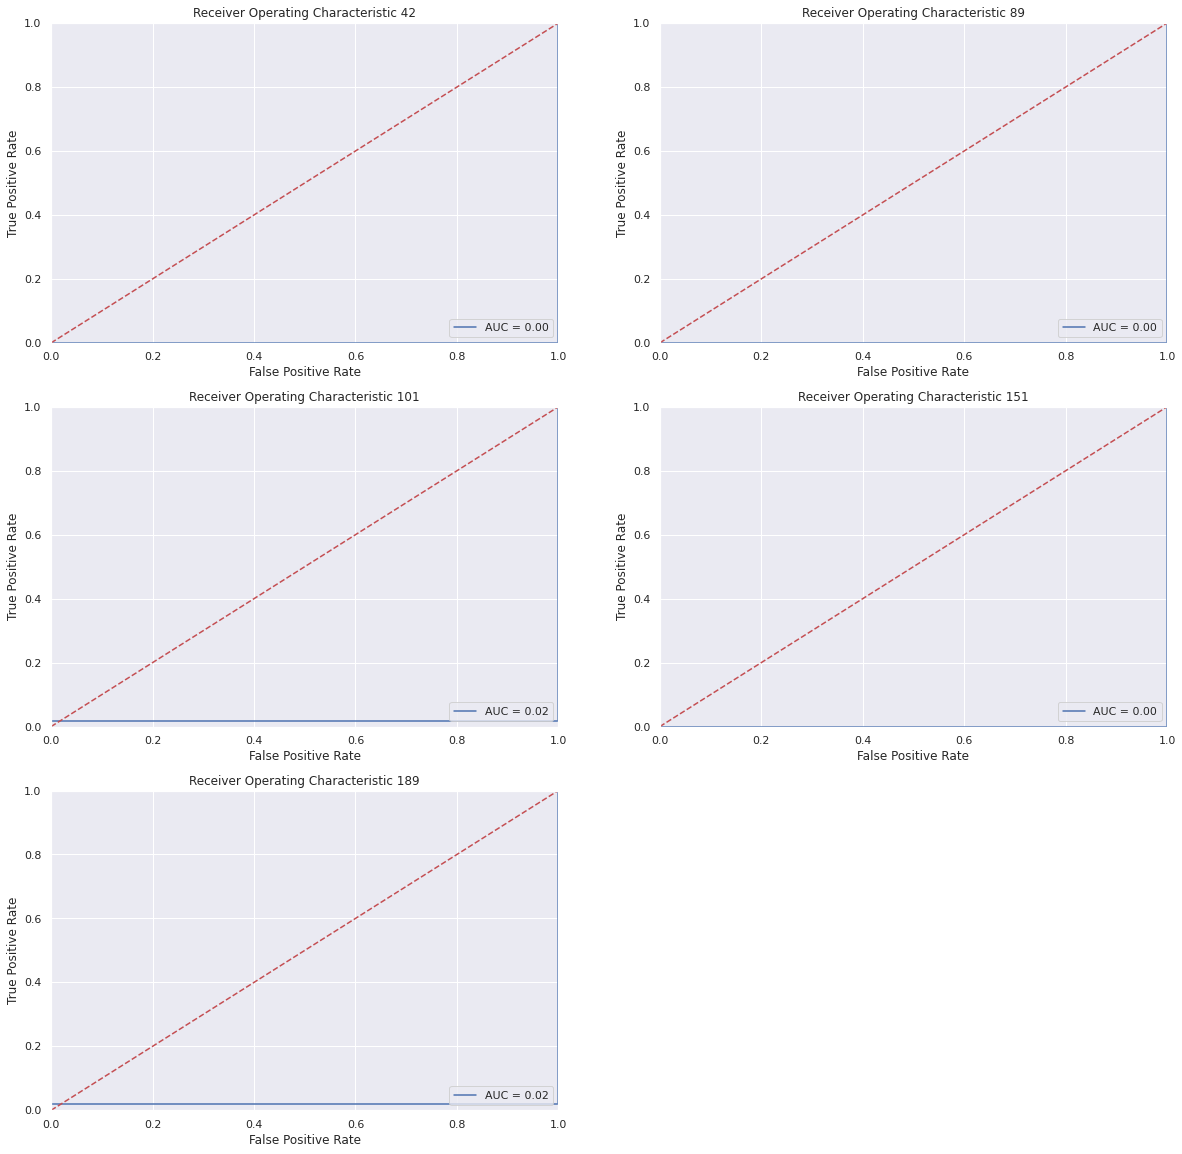

In [301]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

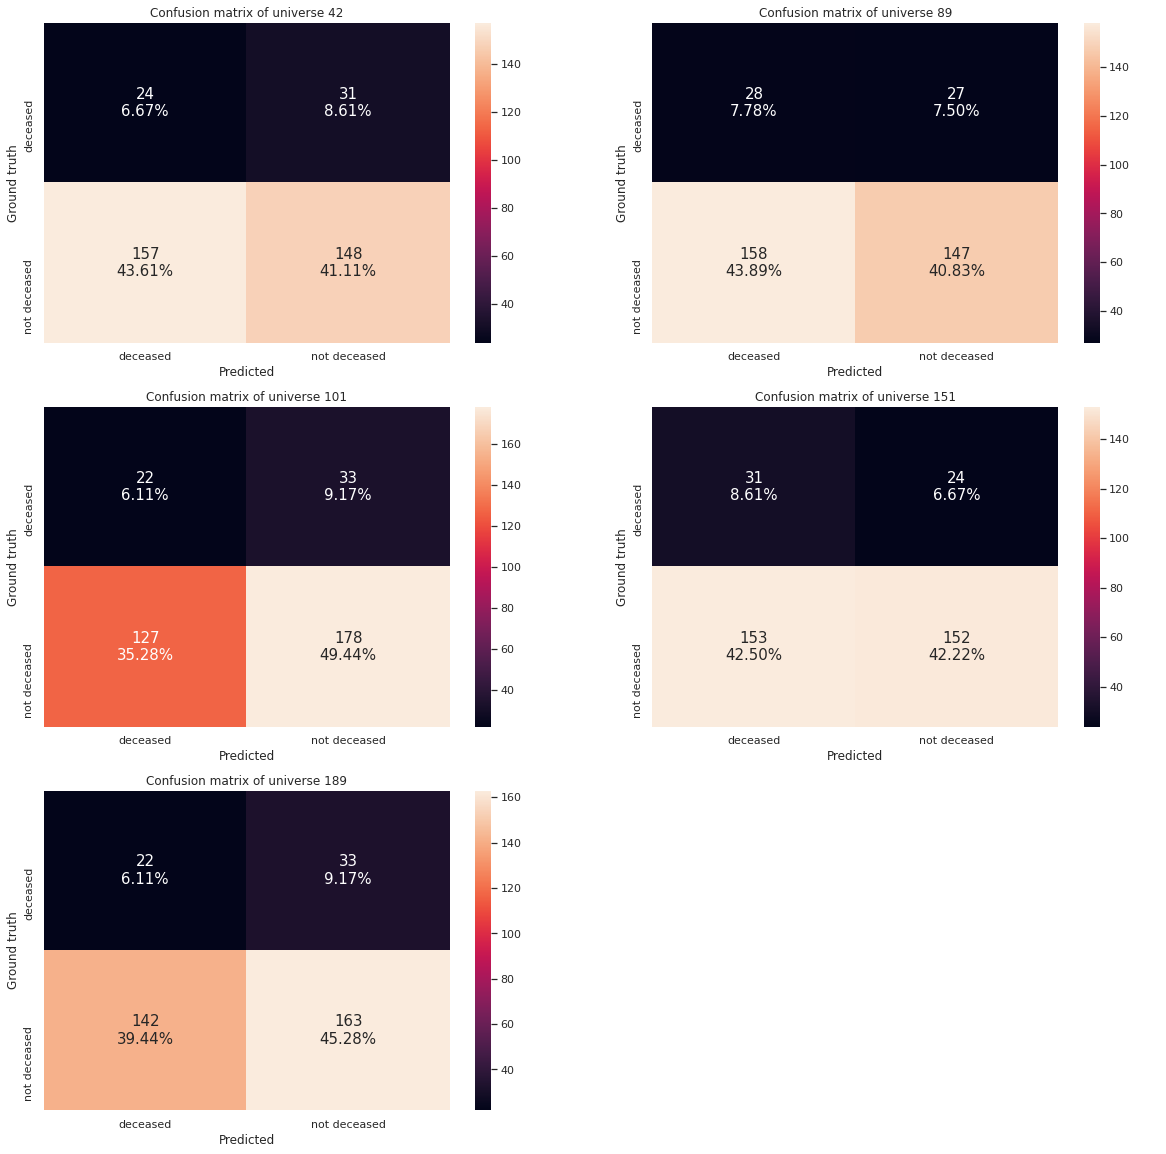

In [257]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

/home/unaice/miniconda3/envs/oc_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1195: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/unaice/miniconda3/envs/oc_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1196: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/home/unaice/miniconda3/envs/oc_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1195: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/unaice/miniconda3/envs/oc_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1196: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
/home/unaice/miniconda3/envs/oc_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1195: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/unaice/miniconda3/e

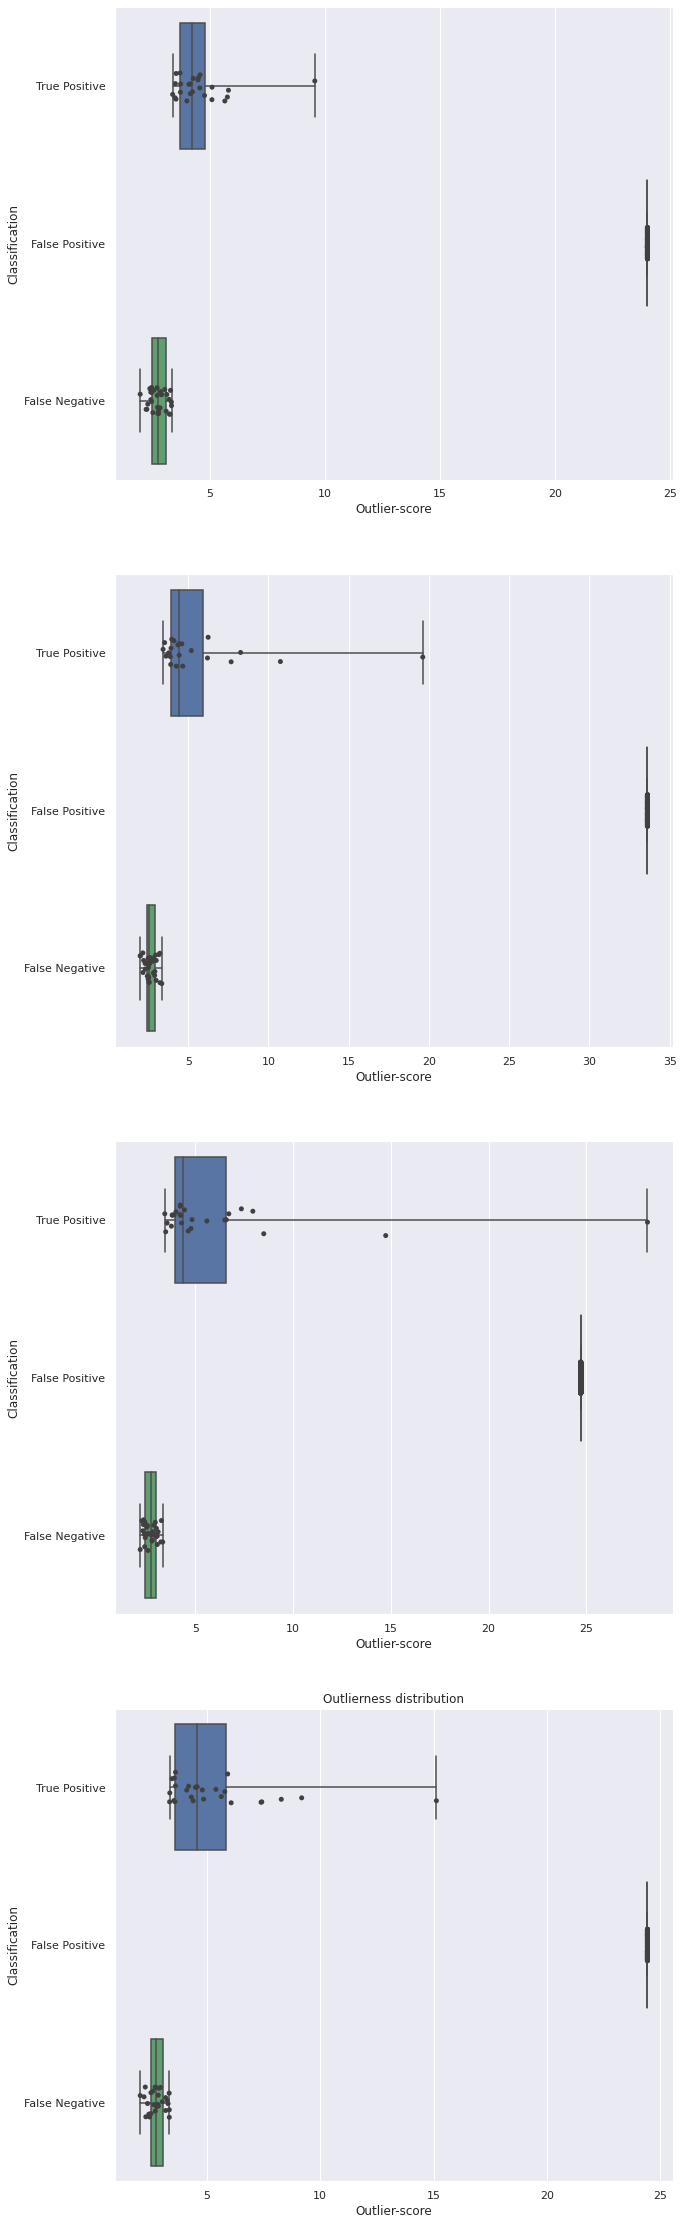

In [287]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

<a id='model:cat_binary'></a>
## Binary (supervised) classification models


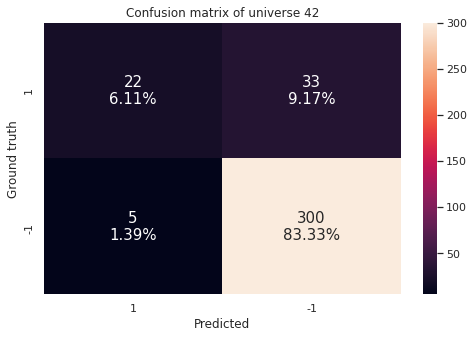

In [191]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='liblinear')
clf.fit(X_collection[42][0], Y_collection[42][0]['ED0DISWHY'])
y_pred = clf.predict(X_collection[42][1])

confusion_matrix_plot(Y_collection[42][1], y_pred, [1,-1], 1, -1, rs=42)

In [180]:
X_collection[42][0]

,CT00000AP,CT000APTT,CT00000DD,CT0000GGT,CT0000GLU,CT0000GOT,CT0000GPT,CT000HCTO,CT0000LDH,CT000LEUC,CT000LINP,CT00MONOP,CT00000NA,CT0000NEU,CT000NEUP,CT0000PCR,CT000PLAQ,CT000000U,CT0000VCM,CD0000AGE,CTHSDXXRATE,CTHSDXXSAT,CD000MSEX,CD000FSEX
0,70.0,35.4,217.0,24.10,92.2,17.8,17.4,45.8,323.3,5.16,23.8,11.2,138.2,3.33,64.6,17.59,142.0,33.7,83.3,43.0,98.0,96.0,1,0
1,62.0,37.2,2022.0,43.60,122.3,26.7,16.0,46.5,383.4,6.23,22.5,7.7,135.2,4.31,69.1,80.18,184.0,27.7,90.6,61.0,70.0,90.0,1,0
2,73.0,35.5,514.0,153.00,135.0,85.0,64.0,40.3,655.0,2.97,13.1,2.7,136.0,2.50,84.2,95.83,71.0,70.0,87.4,66.0,54.0,99.0,1,0
3,71.0,28.3,1131.0,76.00,109.0,96.0,85.0,45.0,1140.0,5.38,13.0,7.1,131.0,4.28,79.5,57.95,200.0,38.0,90.2,55.0,56.0,96.0,1,0
4,79.0,26.0,7076.0,10.80,90.6,18.4,13.6,47.7,449.6,3.59,34.8,12.0,139.6,1.86,51.8,6.03,190.0,24.5,88.7,27.0,68.0,97.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,72.0,28.9,541.0,16.00,99.0,19.0,19.0,34.0,371.0,8.71,6.0,8.3,130.0,7.47,85.7,168.46,86.0,37.0,90.7,69.0,73.0,99.0,1,0
1434,88.0,35.1,2472.8,96.00,95.0,95.0,83.0,42.4,701.0,4.47,15.7,4.3,141.0,3.58,80.0,85.33,103.0,21.0,84.6,51.0,85.0,95.0,1,0
1435,78.0,33.8,496.0,35.00,131.2,26.2,29.8,40.6,487.7,7.31,18.5,9.4,137.4,5.23,71.6,40.33,271.0,20.0,87.5,62.0,72.0,95.0,0,1
1436,78.0,31.5,519.0,271.00,107.0,78.0,56.0,43.5,660.0,7.12,6.6,4.1,133.0,6.35,89.2,227.22,231.0,31.0,85.8,61.0,74.0,97.0,1,0
